In [39]:
import numpy as np
from matplotlib.axes import Axes
from q_channel_approx.plotting.visualize import plot_ess
import matplotlib.pyplot as plt
from q_channel_approx.channel import evolver_fac
from q_channel_approx.training_data import measure_rhoss
from q_channel_approx.unitary_circuits import Circuit

rho0, circuit, thetas, N -> rhoss; delta_t, rhoss, Os -> ess, ts, labels -> plot

theta_evolution :: rho0, thetas, N -> rhoss;

plot_theta_evolution :: rhoss, Os, delta_t, labels (-> ess, ts) -> plot

In [40]:

def theta_evolution(rho0: np.ndarray, circuit: Circuit, thetas: np.ndarray, N: int) -> np.ndarray:
    rho0 = rho0.full()
    dims, _ = rho0.shape
    M = len(thetas)
    rhoss = np.zeros( (M, N+1, dims, dims), dtype=np.complex128 )


    for j, theta in enumerate(thetas):
        rhoss[j, :, :, :] = evolver_fac(circuit=circuit, theta_opt=theta)(rho=rho0, n=N)

    return rhoss

In [41]:
def plot_thetas(rhoss: np.ndarray, Os: list[np.ndarray], delta_t: float, labels: list[str]) -> Axes:
    
    Os = [O.full() for O in Os]

    colors = ["k", "r"]
    
    esss = measure_rhoss(rhoss, Os)

    L, K, N = esss.shape
    ts = np.arange(N) * delta_t

    ax = plt.gca()

    r = len(esss)

    for j, ess in enumerate(esss):
        ax = plot_ess(ts=ts, Ess=ess, labels=labels, colors=colors, alpha=(j+1)/r, ax=ax)

    return ax

In [42]:
def plot_theta_evolution(rho0, Os, labels, circuit, thetas, N, delta_t):
    rhoss = theta_evolution(rho0, circuit, thetas, N)

    return plot_thetas(rhoss, Os, delta_t, labels)

In [43]:
from q_channel_approx.unitary_circuits import TriangularLayoutAB, unitary_circuit_fac
from q_channel_approx.physics_defns import DecaySystem, rho_rand_haar
from q_channel_approx.plotting.plot_observables import create_observables_comp_basis
from q_channel_approx.pprint import comp_basis_labels

In [44]:
qubits = TriangularLayoutAB(m=1, cutoff=1, distance=0.9)
operations = [("rz", "AB"), ("rx", "AB"), ("rz", "AB"), ("ryd ent", "")]
circuit = unitary_circuit_fac(qubits, operations, repeats=1, depth=10)

In [45]:
Os = create_observables_comp_basis(1)
labels = comp_basis_labels(1)

In [46]:
thetas = np.load("both_thetas.npy")

In [47]:
from q_channel_approx.training_data import solve_lindblad_rho0, measure_rhos
from q_channel_approx.physics_defns import DecaySystem, default_jump_operators

In [48]:
m = 1
omegas = (0.4,)
gammas = (0.3,)
ryd_interaction = 0.2

jump_oper = default_jump_operators(m, gammas)
system = DecaySystem(ryd_interaction=ryd_interaction, omegas=omegas, m=m, gammas=gammas)

In [49]:
rho_ref_s, ts = solve_lindblad_rho0(
    rho_rand_haar(1, 4), delta_t=0.5, N=20, s=system, jump_opers=jump_oper
)
e_ref_ss = measure_rhos([r.full() for r in rho_ref_s], [O.full() for O in Os])

In [59]:
my_thetas = np.concatenate((thetas[:3], thetas[3:10:3], thetas[399:]))

c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


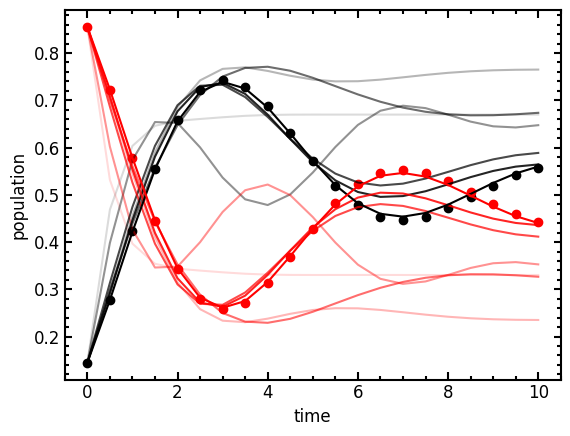

In [61]:
ax=plot_theta_evolution(rho_rand_haar(1, 4), Os, labels, circuit, my_thetas, 20, 0.5)
plt.legend().remove()
ax.scatter(ts, e_ref_ss[0], color="k")
ax.scatter(ts, e_ref_ss[1], color="r")
plt.savefig("theta-evolution.pdf")